## The Darcy's equation (continuous inputs)

## (1) Problem Description
We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function. 

We consider a problem with a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The MultiONet method (Batch)
[DGenNO: A Novel Physics-aware Neural Operator for Solving Forward and Inverse PDE Problems based on Deep, Generative Probabilistic Modeling](https://arxiv.org/pdf/2502.06250)

### (2.1) Prepare data

The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841])
The shape of gridx_train: torch.Size([841, 2])
***********************************
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841])
The shape of u_test: torch.Size([200, 841])
The shape of gridx_test: torch.Size([841, 2])


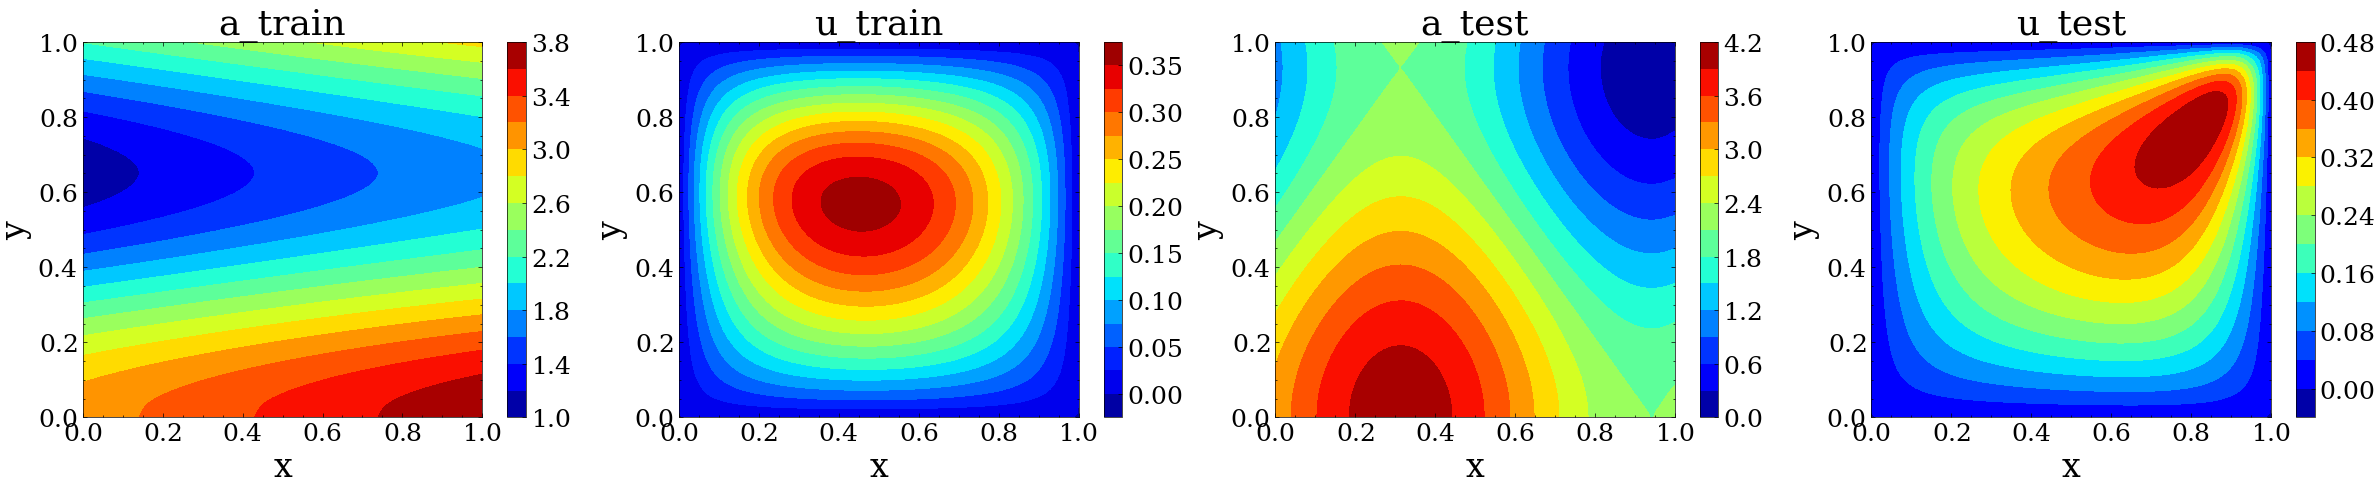

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:1'
dtype = torch.float32

######################################
# Load training data
######################################
from Utils.utils import *
def get_data(data, dtype):
    a = np2tensor(np.array(data["coeff"]).T, dtype)
    u = np2tensor(np.array(data["sol"]).T, dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    ndata = a.shape[0]
    a = a.reshape(ndata, -1)
    u = u.reshape(ndata, -1)
    x = gridx.repeat((ndata, 1, 1))
    
    return a, u, x, gridx
#
data_train = h5py.File('dataset/smh_train.mat', 'r')
data_test = h5py.File('dataset/smh_test_in.mat', 'r')
a_train, u_train, x_train, gridx_train = get_data(data_train, dtype)
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('***********************************')
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx_train]*3+[gridx_test], [a_train[0], u_train[0], a_test[0], u_test[0]], 
                  ['a_train', 'u_train', 'a_test', 'u_test'], lb =0.)

### (2.2) Define the loss class

In [2]:
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']

    def Loss_data(self, a, u, x):
        ''' '''
        u_pred = self.model_u(x, self.model_enc(a))
        #
        loss = self.solver.getLoss(u_pred, u)
        
        return loss

    def Error(self, a, u, x):
        ''' '''
        u_pred = self.model_u(x, self.model_enc(a))
        #
        err = self.solver.getError(u_pred, u)
        
        return err

##############################
# Setup of the solver
##############################
import torch.nn as nn
from Networks.CNNet import CNNet2d
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, nx_size:int, ny_size:int, 
                 dtype, activation:str='SiLU'):
        super(Encoder, self).__init__()
        self.nx_size, self.ny_size = nx_size, ny_size
        self.conv = CNNet2d(conv_arch, fc_arch, 
                            activation_conv=activation, activation_fc=activation,
                            kernel_size=(5,5), stride=2, dtype=dtype)
        
    def forward(self, x):
        '''
        Input:
            x: size(?, ny*nx)
        Return:
            output: size(?, fc_arch[-1])
        '''
        # size(?, ny*nx) -> size(?, 1, ny, nx)
        x = x.reshape(-1, self.ny_size, self.nx_size).unsqueeze(1)
        x = self.conv(x)

        return x
#
model_enc = Encoder(conv_arch=[1, 32, 64, 128], fc_arch=[128*1*1,128], 
                    nx_size=29, ny_size=29, dtype=dtype).to(device)

######################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
netType = 'MultiONetBatch'
#
trunk_layers, trunk_activation = [128]*5, 'SiLU_Sin'
branch_layers, branch_activation = [128]*5, 'SiLU'
model_u = solver.getModel(x_in_size=2, a_in_size=128, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk=trunk_activation, activation_branch=branch_activation, 
                          netType='Batch')

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

273,536 training parameters.
148,997 training parameters.
422,533 total parameters


### (2.3) training and make prediction

In [3]:
# Train the model
model_dict = {'u':model_u, 'enc':model_enc}
solver.train_setup(model_dict, lr=1e-3, optimizer='AdamW', scheduler_type='StepLR', 
                   gamma=1/2, step_size=np.int32(2000/5))
solver.train_batch(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
                       batch_size=50, epochs=2000, epoch_show=100, 
                       **{'save_path':f'saved_models/{netType}/'})

  0%|                                                                                        | 0/2000 [00:00<?, ?it/s]/home/yaohua/anaconda3/envs/dnn-python309/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  5%|███▉                                                                          | 101/2000 [00:14<04:45,  6.65it/s]

Epoch:100 Time:14.3298, loss_train:0.107074, loss_test:0.121041
          lr: 0.001 err_test 0.0225229449570179


 10%|███████▊                                                                      | 201/2000 [00:29<04:28,  6.69it/s]

Epoch:200 Time:29.2435, loss_train:0.053765, loss_test:0.057911
          lr: 0.001 err_test 0.010710158385336399


 15%|███████████▋                                                                  | 301/2000 [00:44<04:14,  6.69it/s]

Epoch:300 Time:44.2389, loss_train:0.045620, loss_test:0.044364
          lr: 0.001 err_test 0.008013044483959675


 20%|███████████████▋                                                              | 401/2000 [00:59<04:06,  6.49it/s]

Epoch:400 Time:59.1878, loss_train:0.042594, loss_test:0.034700
          lr: 0.0005 err_test 0.0066999695263803005


 25%|███████████████████▌                                                          | 501/2000 [01:14<03:44,  6.69it/s]

Epoch:500 Time:74.1640, loss_train:0.022462, loss_test:0.025964
          lr: 0.0005 err_test 0.00511127570644021


 30%|███████████████████████▍                                                      | 601/2000 [01:28<02:47,  8.34it/s]

Epoch:600 Time:88.8613, loss_train:0.019649, loss_test:0.025589
          lr: 0.0005 err_test 0.005134211853146553


 35%|███████████████████████████▎                                                  | 701/2000 [01:43<03:13,  6.72it/s]

Epoch:700 Time:103.8049, loss_train:0.036086, loss_test:0.028553
          lr: 0.0005 err_test 0.005509396083652973


 40%|███████████████████████████████▏                                              | 801/2000 [01:58<03:03,  6.54it/s]

Epoch:800 Time:118.7310, loss_train:0.019008, loss_test:0.018064
          lr: 0.00025 err_test 0.0034168993588536978


 45%|███████████████████████████████████▏                                          | 901/2000 [02:13<02:43,  6.73it/s]

Epoch:900 Time:133.6906, loss_train:0.013043, loss_test:0.013011
          lr: 0.00025 err_test 0.0024794824421405792


 50%|██████████████████████████████████████▌                                      | 1001/2000 [02:28<02:29,  6.68it/s]

Epoch:1000 Time:148.6120, loss_train:0.014995, loss_test:0.014741
          lr: 0.00025 err_test 0.002625036519020796


 55%|██████████████████████████████████████████▍                                  | 1101/2000 [02:43<02:13,  6.71it/s]

Epoch:1100 Time:163.5646, loss_train:0.011449, loss_test:0.012923
          lr: 0.00025 err_test 0.0024029917549341917


 60%|██████████████████████████████████████████████▏                              | 1200/2000 [02:54<01:19, 10.11it/s]

Epoch:1200 Time:174.8323, loss_train:0.009923, loss_test:0.012718
          lr: 0.000125 err_test 0.002421670826151967


 65%|██████████████████████████████████████████████████                           | 1301/2000 [03:04<01:09, 10.09it/s]

Epoch:1300 Time:184.7814, loss_train:0.008239, loss_test:0.008547
          lr: 0.000125 err_test 0.001558086252771318


 70%|█████████████████████████████████████████████████████▉                       | 1401/2000 [03:14<00:59, 10.08it/s]

Epoch:1400 Time:194.7069, loss_train:0.006119, loss_test:0.006287
          lr: 0.000125 err_test 0.0011107801692560315


 75%|█████████████████████████████████████████████████████████▊                   | 1501/2000 [03:24<00:49, 10.03it/s]

Epoch:1500 Time:204.6436, loss_train:0.007252, loss_test:0.008430
          lr: 0.000125 err_test 0.0015403047436848283


 80%|█████████████████████████████████████████████████████████████▋               | 1601/2000 [03:34<00:40,  9.90it/s]

Epoch:1600 Time:214.5710, loss_train:0.006069, loss_test:0.006439
          lr: 6.25e-05 err_test 0.0011440058005973697


 85%|█████████████████████████████████████████████████████████████████▍           | 1701/2000 [03:44<00:29, 10.10it/s]

Epoch:1700 Time:224.5024, loss_train:0.004333, loss_test:0.005038
          lr: 6.25e-05 err_test 0.0008664594497531652


 90%|█████████████████████████████████████████████████████████████████████▎       | 1801/2000 [03:54<00:19, 10.10it/s]

Epoch:1800 Time:234.4165, loss_train:0.004836, loss_test:0.006357
          lr: 6.25e-05 err_test 0.0011294917203485966


 95%|█████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [04:04<00:09, 10.10it/s]

Epoch:1900 Time:244.3505, loss_train:0.004788, loss_test:0.005858
          lr: 6.25e-05 err_test 0.0010621860856190324


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:14<00:00,  7.86it/s]


Epoch:2000 Time:254.2933, loss_train:0.003889, loss_test:0.004700
          lr: 3.125e-05 err_test 0.0008029526215977967
The total training time is 254.3012


### (2.4) make prediction

The test l2 error: tensor(0.0008)


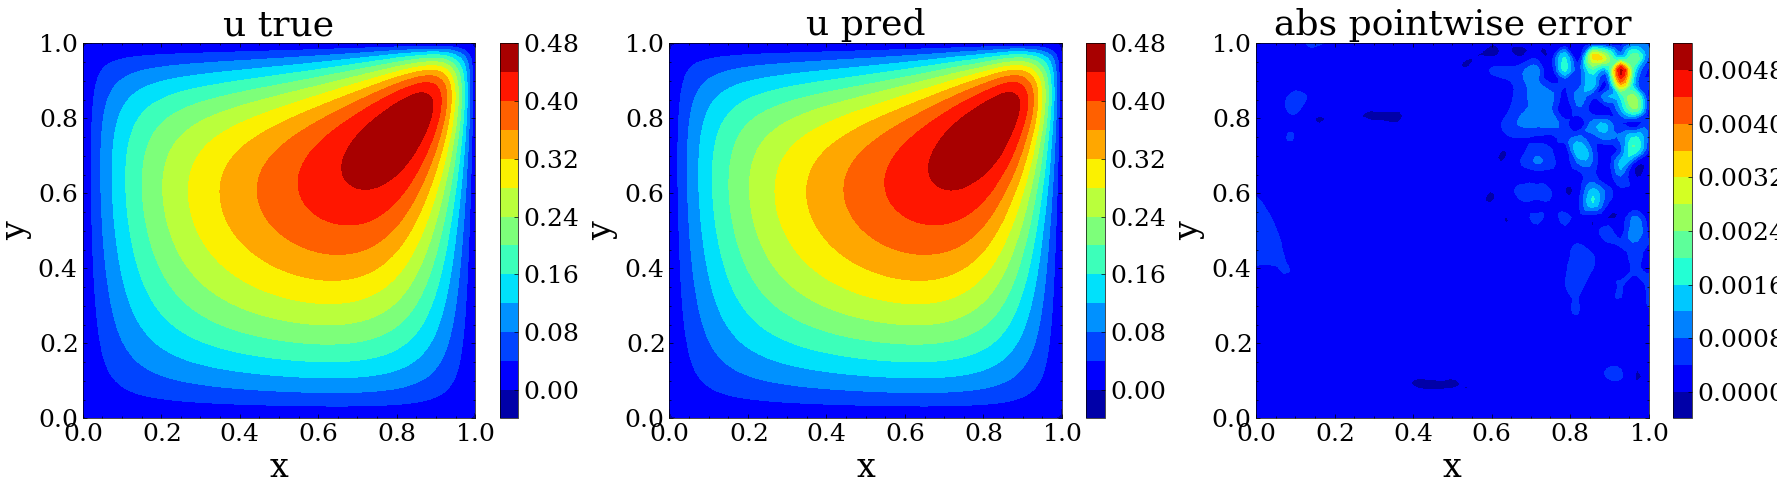

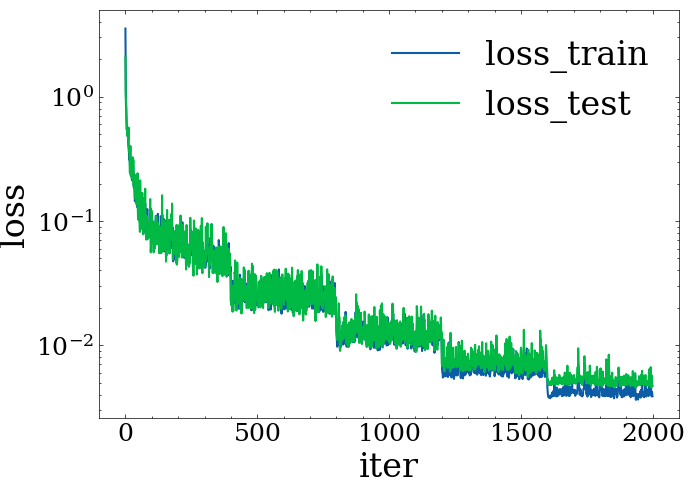

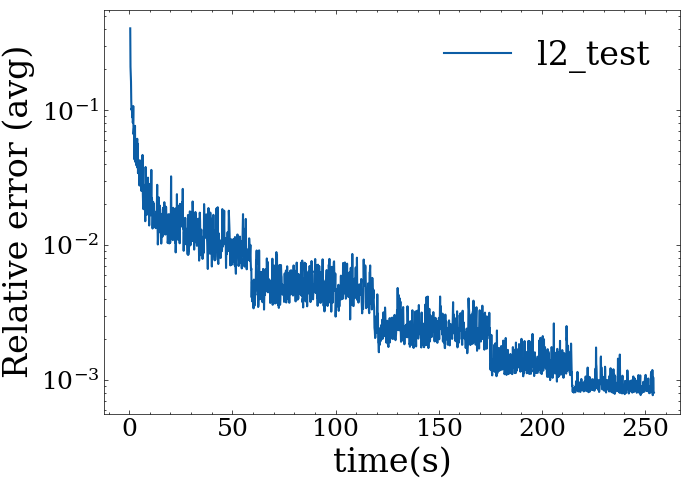

In [4]:
#####################################
# Load the trained model
#####################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', 
                                 name='model_multionet_final')

#########################################
data_test = h5py.File('./dataset/smh_test_in.mat', 'r')
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
with torch.no_grad():
    beta = model_trained['enc'](a_test.to(device))
    u_pred = model_trained['u'](x_test.to(device), beta)
    u_pred = u_pred.detach().cpu()
print('The test l2 error:', solver.getError(u_pred, u_test))
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx_test, [u_test[0], u_pred[0], torch.abs(u_test[0]-u_pred[0])], 
                  ['u true', 'u pred', 'abs pointwise error'], lb=0.)
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_multionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']], [loss_saved['l2_test']], ['l2_test'])